#import libraries

In [1]:
!pip install spectral
import keras
import spectral
from matplotlib import pyplot as plt

import scipy
from scipy.io import loadmat

import sklearn as sk
from sklearn.model_selection import train_test_split
from scipy.stats import mode
from keras.utils import np_utils
from sklearn.metrics import classification_report

from sklearn.decomposition import PCA
import numpy as np
import gzip
%matplotlib inline
from keras.models import Model
from keras.optimizers import RMSprop
from keras.layers import Input,Dense,Flatten,Dropout,merge,Reshape,Conv3D,Conv2D,MaxPooling3D,MaxPooling2D,UpSampling3D,Conv3DTranspose,UpSampling2D,Conv2DTranspose
from keras.layers.normalization import BatchNormalization
from keras.models import Model,Sequential
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adadelta, RMSprop,SGD,Adam
from keras import regularizers
from keras import backend as K


     |████████████████████████████████| 184kB 32.0MB/s 
  Created wheel for spectral: filename=spectral-0.22.2-cp37-none-any.whl size=212955 sha256=b766c6ef54c83f753bd91f6e1aaa0b14b19b4583d58c5c0284d4c854a4472d2b
  Stored in directory: /root/.cache/pip/wheels/fb/00/da/ac778d1ab6e196cb7f56d104d4dfdfc0aad4e2b208275c0726
Successfully built spectral


#load dataset

In [2]:
!wget http://www.ehu.eus/ccwintco/uploads/e/ee/PaviaU.mat    http://www.ehu.eus/ccwintco/uploads/5/50/PaviaU_gt.mat

--2021-06-03 10:52:08--  http://www.ehu.eus/ccwintco/uploads/e/ee/PaviaU.mat
Resolving www.ehu.eus (www.ehu.eus)... 158.227.0.65, 2001:720:1410::65
Connecting to www.ehu.eus (www.ehu.eus)|158.227.0.65|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 34806917 (33M)
Saving to: ‘PaviaU.mat’

PaviaU.mat          100%[===================>]  33.19M   816KB/s    in 42s     

2021-06-03 10:52:51 (802 KB/s) - ‘PaviaU.mat’ saved [34806917/34806917]

--2021-06-03 10:52:51--  http://www.ehu.eus/ccwintco/uploads/5/50/PaviaU_gt.mat
Reusing existing connection to www.ehu.eus:80.
HTTP request sent, awaiting response... 200 OK
Length: 11005 (11K)
Saving to: ‘PaviaU_gt.mat’

PaviaU_gt.mat       100%[===================>]  10.75K  --.-KB/s    in 0s      

2021-06-03 10:52:51 (248 MB/s) - ‘PaviaU_gt.mat’ saved [11005/11005]

FINISHED --2021-06-03 10:52:51--
Total wall clock time: 43s
Downloaded: 2 files, 33M in 42s (802 KB/s)


In [3]:
X = loadmat('PaviaU.mat')['paviaU']
y = loadmat('PaviaU_gt.mat')['paviaU_gt']
print("Load dataset\n")
print(f"X shape : {X.shape}\ny shape : {y.shape}\n\n\n")

Load dataset

X shape : (610, 340, 103)
y shape : (610, 340)





#applying pca

In [4]:
def apply_pca(X,number_of_components = 8):
  
  # Reshaping X from image dimensions to a list
  temp_X = np.reshape(X,(-1,X.shape[2]))
  print(f"temp_X shape : {temp_X.shape}")
  
  # Creating an objcect of class PCA with number of components 100
  pca = PCA(n_components = number_of_components, whiten = True)
  
  # Applying and transforming dataset by PCA by removing the last column that is labelled column
  pca_X = pca.fit_transform(temp_X[:,:-1])

  # Reshaping new_X back to image dimensions with reduced number of bands
  new_X = np.reshape(pca_X, (X.shape[0],X.shape[1], number_of_components))
  
  print(f"X shape after applying PCA dimensionality reduction technique : {new_X .shape}")
 
  return new_X, pca


number_of_components = 10

# Passing number of components 20 for PCA to the function apply_pca
X,pca = apply_pca(X,number_of_components)

temp_X shape : (207400, 103)
X shape after applying PCA dimensionality reduction technique : (610, 340, 10)


In [5]:
def zero_padding_X(X, margin):

  # Creating a numpy 3D matrix of zeros with the required shape for zero padding
  zero_padded_X = np.zeros((X.shape[0]+2*margin, X.shape[1]+2*margin, X.shape[2]))

  # Offset is the starting address of hyperspectral image within zero_padded_X 
  offset = margin 

  # Copying the contents of X into zero_padded_x with correct offset address 
  zero_padded_X[offset:X.shape[0]+offset, offset:X.shape[1]+offset,:] = X

  print(f"The shape of X after zero padding : {zero_padded_X.shape}")

  return zero_padded_X 

In [6]:
def zero_padding_y(y, margin):

  # Creating a numpy 2D matrix of zeros with the required shape for zero padding
  zero_padded_y = np.zeros((y.shape[0]+2*margin, y.shape[1]+2*margin))

  # Offset is the starting address of hyperspectral image within zero_padded_X 
  offset = margin 

  # Copying the contents of X into zero_padded_x with correct offset address 
  zero_padded_y[offset:y.shape[0]+offset, offset:y.shape[1]+offset] = y

  print(f"The shape of y after zero padding : {zero_padded_y.shape}")
  print(np.unique(zero_padded_y))
  return zero_padded_y 

In [7]:
def create_image_cuboids(X, y, window_size=11, remove_class_zero = False, labelling_type = "center"):

  stride = 1
  
  # Calculating the margin required for zero padding for a particular window size (or smaller cube size)
  zero_padding_margin = int((window_size - stride) / 2)
  
  # Applying zero padding to X
  zero_padded_X = zero_padding_X(X, zero_padding_margin)

  # Apply zero padding to y
  zero_padded_y = zero_padding_y(y, zero_padding_margin)

  # Create a 4D matrix of smaller cuboids of zeros 
  X_cuboids = np.zeros((X.shape[0]*X.shape[1], window_size, window_size, X.shape[2]))

  # Create a matrix for assigning labels to smaller cuboids X_cuboids
  y_cuboids_labels = np.zeros((X.shape[0]*X.shape[1]))

  offset = zero_padding_margin

  # Traversing through X and y to split X and y accordingly
  index = 0
  for i in range(offset,zero_padded_X.shape[0]-offset):
    for j in range(offset, zero_padded_X.shape[1]-offset):

        # Extracting smaller cube from zero_padded_X
        cube = zero_padded_X[i-offset:i+offset+1,j-offset:j+offset+1]

        # Storing the extracted cube from zero_padded_X into X_cuboids
        X_cuboids[index,:,:,:] = cube 

        # Storing the extracted matrix from zero_padded_y into y_labels
        y_labels = zero_padded_y[i-offset:i+offset+1,j-offset:j+offset+1]
        
        # Calculating mode of y_labels matrix
        #y_label = mode(y_labels, axis=None, nan_policy="omit")
        #print(y_label)

        # Assigning label to a particular index's X_cuboid
        #y_cuboids_labels[index] = int(y_label[0])
        #y_cuboids_labels[index] = y[i-offset,j-offset]

        if labelling_type=="majority":
          
          # Calculating mode of y_labels matrix
          y_label = mode(y_labels, axis=None, nan_policy="omit")
          
          # Assigning label to a particular index's X_cuboid
          y_cuboids_labels[index] = int(y_label[0])

        elif labelling_type=="center":

          y_label = y_labels[y_labels.shape[0]//2,y_labels.shape[1]//2]
          y_cuboids_labels[index] = int(y_label)

        index+=1   
  print(np.unique(y_cuboids_labels))
  # Removes class zero from X_cuboids and y_cuboids_labels
  if remove_class_zero:
        X_cuboids = X_cuboids[y_cuboids_labels>0,:,:,:]
        y_cuboids_labels = y_cuboids_labels[y_cuboids_labels>0]
        print(np.unique(y_cuboids_labels))
        y_cuboids_labels -= 1 
        print(np.unique(y_cuboids_labels))
  
  print(f"The shape of X_cuboids : {X_cuboids.shape}")
  print(f"The shape of y_cuboids_labels : {y_cuboids_labels.shape}")
 
  return X_cuboids,y_cuboids_labels

window_size=11
X,y = create_image_cuboids(X,y,window_size)

The shape of X after zero padding : (620, 350, 10)
The shape of y after zero padding : (620, 350)
[0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]
[0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]
The shape of X_cuboids : (207400, 11, 11, 10)
The shape of y_cuboids_labels : (207400,)


#splitting dataset

In [8]:
def split_data(X, y,test_ratio, random_state = 10):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_ratio, random_state=random_state)
    print(f"X_train shape : {X_train.shape}")
    print(f"y_train shape : {y_train.shape}")
    print(f"X_test shape  : {X_test.shape}")
    print(f"y_test shape  : {y_test.shape}")
    
    return X_train, X_test, y_train, y_test

test_ratio = 0.33 

X_train, X_test, y_train, y_test = split_data(X, y, test_ratio)


def count_frequency(y,name):         
    unique, counts = np.unique(y, return_counts=True)
    elements=dict(zip(unique, counts))
    print(f"Number of elements present in each class of {name}: {elements}") 

count_frequency(y_train,name="y_train")    
count_frequency(y_test,name="y_test")


X_train shape : (138958, 11, 11, 10)
y_train shape : (138958,)
X_test shape  : (68442, 11, 11, 10)
y_test shape  : (68442,)
Number of elements present in each class of y_train: {0.0: 110348, 1.0: 4433, 2.0: 12516, 3.0: 1387, 4.0: 1988, 5.0: 910, 6.0: 3402, 7.0: 874, 8.0: 2458, 9.0: 642}
Number of elements present in each class of y_test: {0.0: 54276, 1.0: 2198, 2.0: 6133, 3.0: 712, 4.0: 1076, 5.0: 435, 6.0: 1627, 7.0: 456, 8.0: 1224, 9.0: 305}


#convolution

In [9]:
number_of_components = 10
X_train = X_train.reshape(-1, window_size, window_size, number_of_components , 1)
X_train.shape

y_train = np_utils.to_categorical(y_train)
y_train.shape

(138958, 10)

In [10]:
num_classes=10
S=window_size
L=number_of_components
input_img = Input((S, S, L, 1))
def encoder(input_img):
    #encoder
    conv1 = Conv3D(32, (3, 3, 3), activation='relu', padding='same')(input_img) 
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv3D(32, (3, 3, 3), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling3D(pool_size=(2, 2, 2))(conv1) 
    conv2 = Conv3D(64, (3, 3, 3), activation='relu', padding='same')(pool1) 
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv3D(64, (3, 3, 3), activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling3D(pool_size=(2, 2, 2))(conv2) 
    conv3 = Conv3D(128, (3, 3, 3), activation='relu', padding='same')(pool2) 
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv3D(128, (3, 3, 3), activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    conv4 = Conv3D(256, (3, 3, 3), activation='relu', padding='same')(conv3) 
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv3D(256, (3, 3, 3), activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    return conv4

def decoder(conv4):    
    #decoder
    conv5 = Conv3D(128, (3, 3, 3), activation='relu', padding='same')(conv4) 
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv3D(128, (3, 3, 3), activation='relu', padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)
    conv6 = Conv3D(64, (3, 3, 3), activation='relu', padding='same')(conv5) 
    conv6 = BatchNormalization()(conv6)
    conv6 = Conv3D(64, (3, 3, 3), activation='relu', padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)
    up1 = UpSampling3D((2,2,2))(conv6) 
    conv7 = Conv3D(32, (3, 3, 3), activation='relu', padding='same')(up1) 
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv3D(32, (3, 3, 3), activation='relu', padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)
    up2 = UpSampling3D((2,2,2))(conv7) 
    decoded = Conv3D(1, (3, 3, 3), activation='sigmoid', padding='same')(up2)
    return decoded

def fc(enco):
    flat = Flatten()(enco)
    den = Dense(128, activation='relu')(flat)
    out = Dense(num_classes, activation='softmax')(den)
    return out    

In [11]:
autoencoder = Model(input_img, decoder(encoder(input_img)))
autoencoder.compile(loss='mean_squared_error', optimizer = RMSprop())
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 11, 11, 10, 1)]   0         
_________________________________________________________________
conv3d (Conv3D)              (None, 11, 11, 10, 32)    896       
_________________________________________________________________
batch_normalization (BatchNo (None, 11, 11, 10, 32)    128       
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 11, 11, 10, 32)    27680     
_________________________________________________________________
batch_normalization_1 (Batch (None, 11, 11, 10, 32)    128       
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 5, 5, 5, 32)       0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 5, 5, 5, 64)       55360 

In [12]:
encode = encoder(input_img)
autoencoder1 = Model(input_img,fc(encode))
autoencoder1.compile(loss='mean_squared_error', optimizer = RMSprop())
autoencoder1.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 11, 11, 10, 1)]   0         
_________________________________________________________________
conv3d_15 (Conv3D)           (None, 11, 11, 10, 32)    896       
_________________________________________________________________
batch_normalization_14 (Batc (None, 11, 11, 10, 32)    128       
_________________________________________________________________
conv3d_16 (Conv3D)           (None, 11, 11, 10, 32)    27680     
_________________________________________________________________
batch_normalization_15 (Batc (None, 11, 11, 10, 32)    128       
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (None, 5, 5, 5, 32)       0         
_________________________________________________________________
conv3d_17 (Conv3D)           (None, 5, 5, 5, 64)       5536

In [13]:
# compiling the model
adam = Adam(learning_rate=0.001, decay=1e-06)
autoencoder1.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [14]:
# checkpoint
filepath = "best-model.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [15]:
history = autoencoder1.fit(X_train, y_train, batch_size=128,epochs=10,callbacks=callbacks_list)

Epoch 1/10
1086/1086 [==============================] - 93s 43ms/step - loss: 0.4196 - accuracy: 0.8697

Epoch 00001: accuracy improved from -inf to 0.91091, saving model to best-model.hdf5
Epoch 2/10
1086/1086 [==============================] - 46s 42ms/step - loss: 0.1239 - accuracy: 0.9510

Epoch 00002: accuracy improved from 0.91091 to 0.95294, saving model to best-model.hdf5
Epoch 3/10
1086/1086 [==============================] - 46s 42ms/step - loss: 0.0948 - accuracy: 0.9620

Epoch 00003: accuracy improved from 0.95294 to 0.96338, saving model to best-model.hdf5
Epoch 4/10
1086/1086 [==============================] - 45s 42ms/step - loss: 0.0755 - accuracy: 0.9708

Epoch 00004: accuracy improved from 0.96338 to 0.96976, saving model to best-model.hdf5
Epoch 5/10
1086/1086 [==============================] - 45s 42ms/step - loss: 0.0691 - accuracy: 0.9726

Epoch 00005: accuracy improved from 0.96976 to 0.97314, saving model to best-model.hdf5
Epoch 6/10
1086/1086 [================

In [16]:
X_test = X_test.reshape(-1, window_size, window_size, number_of_components, 1)
X_test.shape


(68442, 11, 11, 10, 1)

In [17]:
y_test1 = np_utils.to_categorical(y_test)
y_test1.shape

(68442, 10)

In [18]:

predict_test = autoencoder1.predict(X_test)
pred_test = np.argmax(predict_test, axis=1)
pred_test.shape

classification = classification_report(np.argmax(y_test1, axis=1), pred_test)
print(classification)

              precision    recall  f1-score   support

           0       0.98      0.98      0.98     54276
           1       0.88      0.94      0.91      2198
           2       0.98      0.97      0.98      6133
           3       0.88      0.93      0.91       712
           4       0.77      0.82      0.79      1076
           5       0.94      0.90      0.92       435
           6       0.99      0.97      0.98      1627
           7       0.92      0.97      0.95       456
           8       0.86      0.87      0.86      1224
           9       0.80      0.90      0.85       305

    accuracy                           0.97     68442
   macro avg       0.90      0.93      0.91     68442
weighted avg       0.97      0.97      0.97     68442



In [19]:
X = loadmat('PaviaU.mat')['paviaU']
y = loadmat('PaviaU_gt.mat')['paviaU_gt']
print("Load dataset\n")
print(f"X shape : {X.shape}\ny shape : {y.shape}\n\n\n")


Load dataset

X shape : (610, 340, 103)
y shape : (610, 340)





In [20]:
height = y.shape[0]
width = y.shape[1]

In [21]:
X,pca = apply_pca(X, number_of_components)

temp_X shape : (207400, 103)
X shape after applying PCA dimensionality reduction technique : (610, 340, 10)


In [22]:
X = zero_padding_X(X, window_size//2)

The shape of X after zero padding : (620, 350, 10)


In [23]:
def Patch(data,height_index,width_index, window_size):
    height_slice = slice(height_index, height_index+window_size)
    width_slice = slice(width_index, width_index+window_size)
    patch = data[height_slice, width_slice, :]
    
    return patch

In [24]:
from tqdm.auto import trange


outputs = np.zeros((height,width))
for i in trange(height, desc="Building image"):
    for j in trange(width,leave=False):
        #target = int(y[i,j])
        #if target == 0 :
            #continue
        #elif target == y[287,332]:
          #continue
        #else :
        image_patch=Patch(X,i,j,window_size=11)
        X_test_image = image_patch.reshape(1,image_patch.shape[0],image_patch.shape[1], image_patch.shape[2], 1).astype('float32')                                   
        prediction = (autoencoder1.predict(X_test_image))
        prediction = np.argmax(prediction, axis=1)
        outputs[i][j] = prediction+1

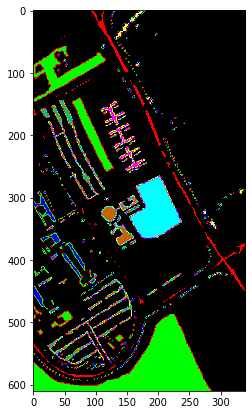

In [25]:
ground_truth = spectral.imshow(classes = y,figsize =(7,7))

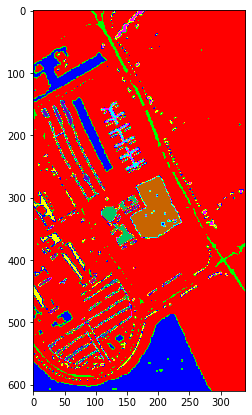

In [26]:
predict_image = spectral.imshow(classes = outputs.astype(int),figsize =(7,7))

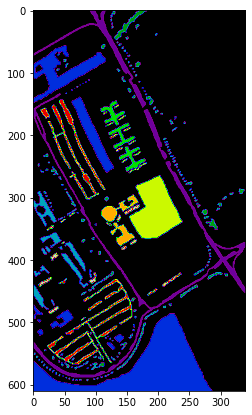

In [28]:
plt.figure(figsize = (7,7))
plt.imshow(y, cmap='nipy_spectral');

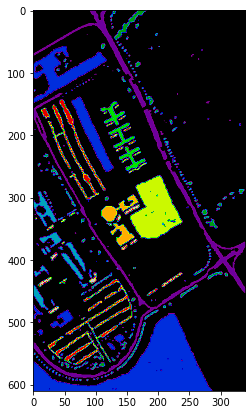

In [27]:
plt.figure(figsize = (7,7))
plt.imshow(outputs, cmap='nipy_spectral');